In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
#from theanoCortexLib import kernel2connection, gkern2
from topologyLib import *
import scipy.ndimage.filters as fi
from time import time
%matplotlib inline

In [4]:
# Need to tune for width and intensity too
def generateMovingFFT(F, iteration, direction, sigma, intensity, noise=0.2, size = 15):
    aux1 = 1#(1/(sigma*np.sqrt(2*np.pi)))
    x = np.array(range(size))
    res = aux1*np.exp(-np.power(x-F,2)/(2.*(np.power(sigma,2))))
    #res = res #+ (np.random.rand(size)-0.5)*noise+noise/2
    x=res 
    #plt.plot(res)
    #plt.show()
    return x
def sigmoid(x,k):
    return 1 / (1 + np.exp(-x))


3 -1 0


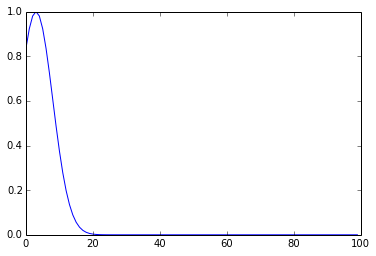

3 -1 1


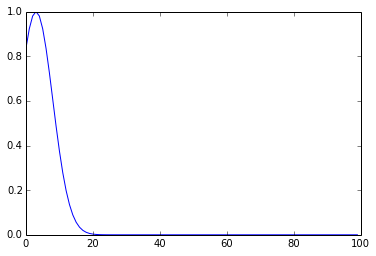

3 -1 2


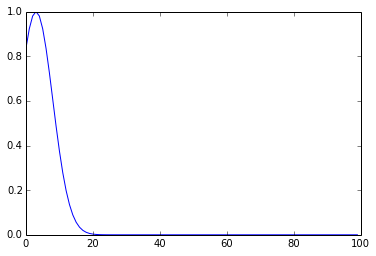

3 -1 3


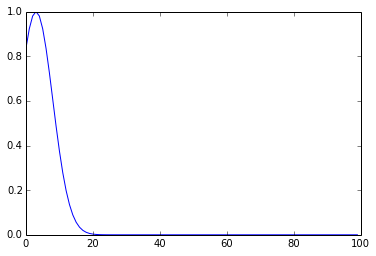

3 -1 4


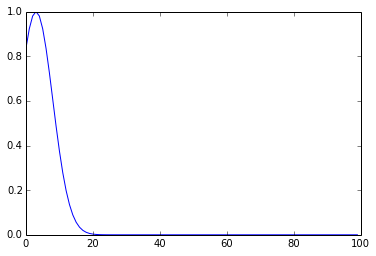

3 -1 5


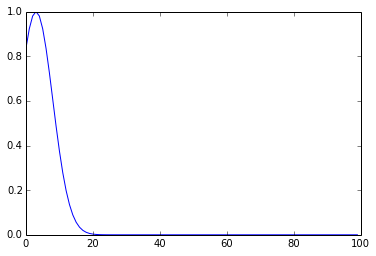

3 -1 6


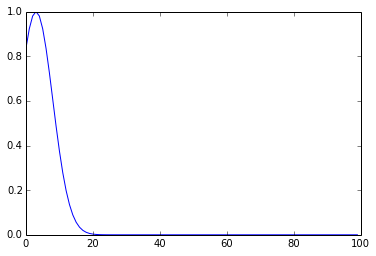

3 -1 7


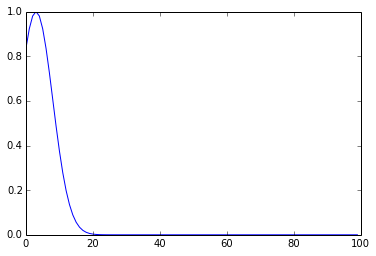

3 -1 8


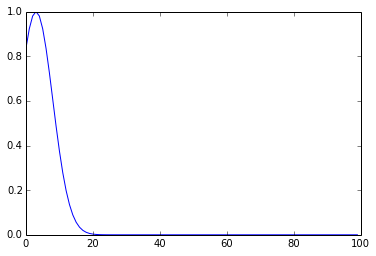

3 -1 9


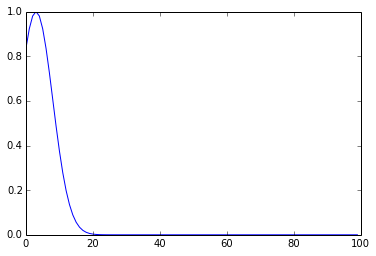

3 -1 10


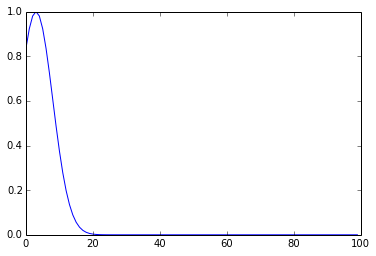

3 -1 11


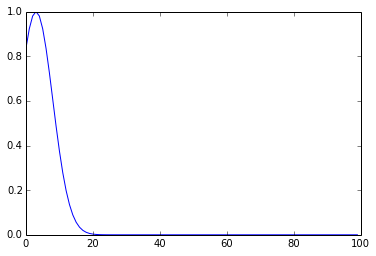

3 -1 12


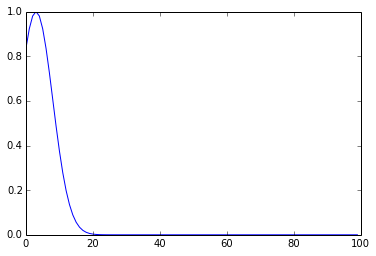

3 -1 13


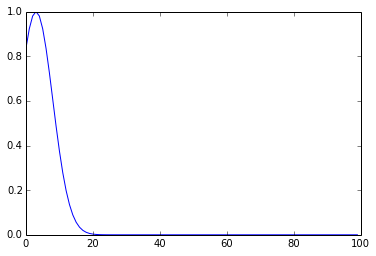

0 0 14


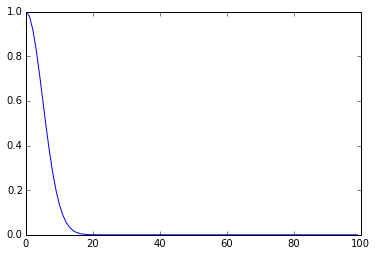

0 0 15


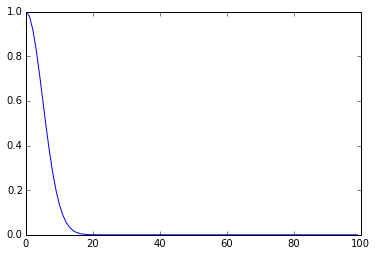

0 0 16


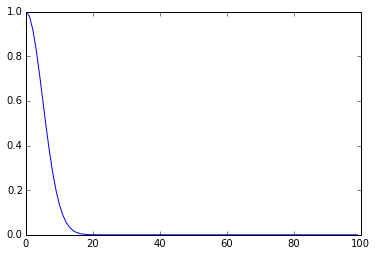

0 0 17


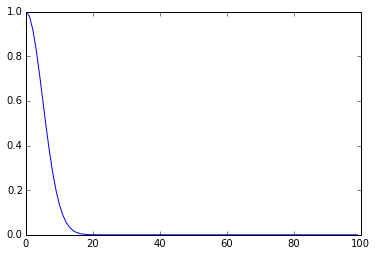

0 0 18


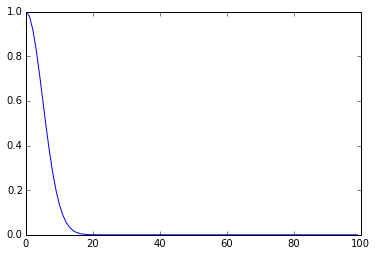

0 0 19


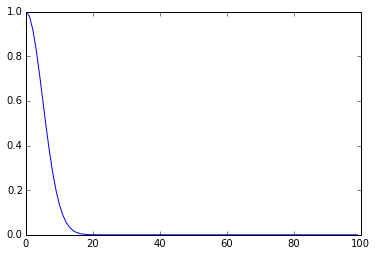

0 0 20


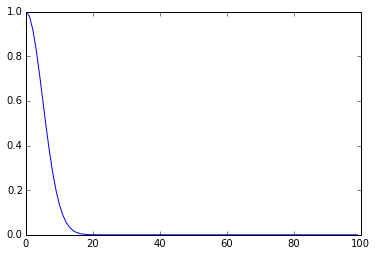

0 0 21


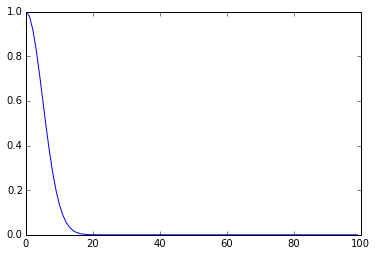

0 0 22


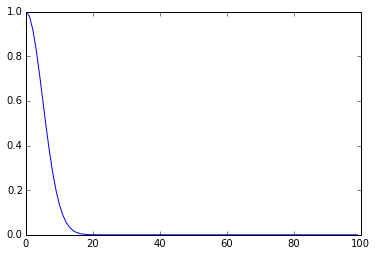

0 0 23


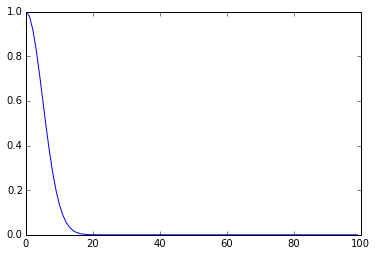

0 0 24


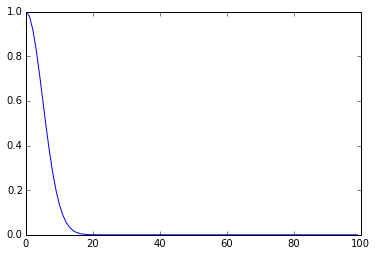

In [6]:
# Test the FFT Generation
freqs = [0,3,6,9,12,15]
dirs = [-1,0,1]
for i in range(25):
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    print F, D, i
        
    plt.plot(generateMovingFFT(F,i,D,5,.6,.02,100))
    plt.show()

(46, 1)


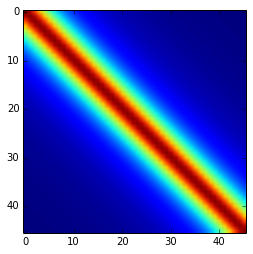

(7, 7)
Remember to always check how is the kernel!!!


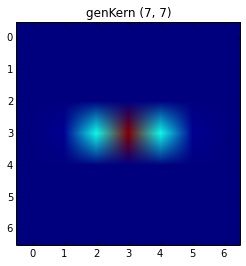

[info] Kernel shape: (7, 7)
[info] Connection Matrix shape: (15, 46)
3.5
0.5
here!!!!!


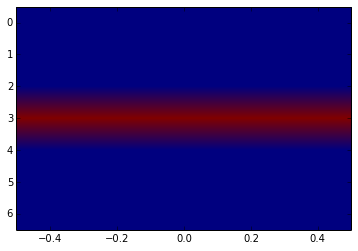

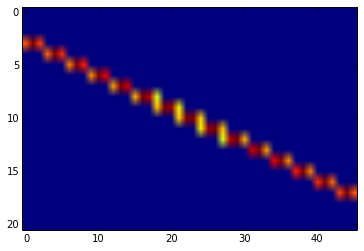

updown!!
[info] Shape was fit from (21, 46) to (15, 46)


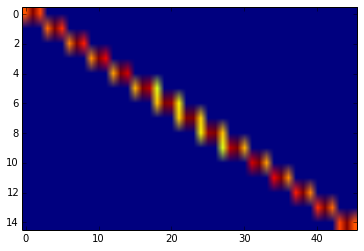

Shape = (15, 46)


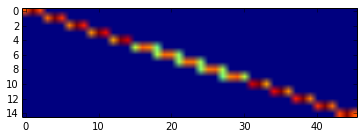

In [23]:
# Re initialize variables: 
N=(46,1)
max_distance_x= 10. #units
max_distance_y= 1. #units
neurons = np.zeros(N)

x = np.arange(0,max_distance_x,max_distance_x/N[0]).reshape(N[0],1)*np.ones(N)
y = np.arange(0,max_distance_y,max_distance_y/N[1]).reshape(1,N[1])*np.ones(N)
x=x.reshape(N)
y=y.reshape(N)
print y.shape

connections = np.identity((neurons.size))

distances = np.zeros(connections.shape)
x = x*np.ones((x.size,x.size))
y = y*np.ones((y.size,y.size))

dx = x-x.transpose()
dy = y-y.transpose()

distances = dx**2+dy**2



dw = np.zeros(connections.shape)
dC = np.zeros(connections.shape)
k=1 #influence of distance
K=0.5  #Max probability
_distances = 1/(1+k*distances)
plt.imshow(_distances)
plt.show()
aux_kernel = np.ones((1,2*distances.shape[1]))


freqs = [0,3,6,9,12,15]
dirs = [-1,0,1]
i_shape = (15,1)
X=np.array(neurons)
inp = np.zeros(i_shape)
LR=0.001

# create nxn zeros
kern_shape=(7,7)
sigma = [3,1]
kern1 = gkern2(kern_shape,sigma)
#kern1 = np.zeros(filter_shape)
Wi = kernel2connection(kern1, i_shape, N)
#Wi /= np.sum(Wi,1).reshape((Wi.shape[0],1))*15
print 'Shape = ' + str(Wi.shape)
if np.sum(Wi,1)[0] != 1:
    Wi /= np.sum(Wi,1).reshape((Wi.shape[0],1))
plt.imshow(Wi)
c_inp = Wi

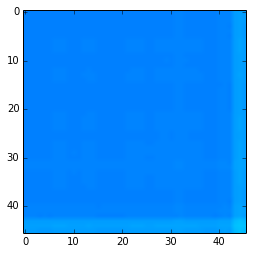

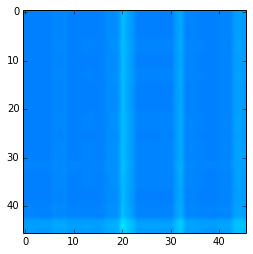

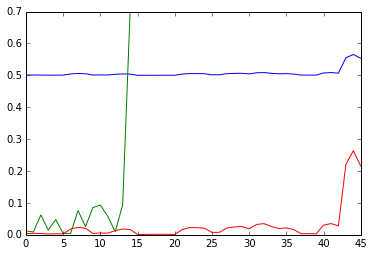

In [32]:
# Run simulation
C=0.0000001
alpha = 0.99991
a=connections
LR=0.9
asd=0
X=np.zeros(neurons.shape)
not_identity=(np.identity(X.size)==0) #Will never create connections with oneself
W_recursive = 0.000005

for i in range(1000):
    #X = np.random.rand(N[0],N[1])
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    #Generate input
    inp = generateMovingFFT(F,i,D,noise=0.1)
    #Compute network activity
    X=alpha*(np.dot(c_inp.T,inp) + W_recursive*np.dot(connections,X))+(1-(1+W_recursive)*alpha)*np.dot(np.identity(X.size),X)
    X=sigmoid(X,1)
    mask_C_0 = connections<=0
    
    # Compute probability of connection
    probabilities = K*np.dot(connections*_distances,_distances.transpose())*mask_C_0 # sg.convolve(K*connections*np.dot(_distances,_distances.transpose()), aux_kernel,'same')*mask_C_0.mask
    # Compute Hebbian plasticity (to weight the probability)
    dw = np.dot(X,X.transpose())-np.dot(X, np.dot(X.transpose(),C*np.ones((connections.shape[0],connections.shape[1]))) )# Oja, right now
    #Warnings!!
    if np.isnan(dw).any():
        print 'error: NAN found in dw. At iteration: ' + str(i)
        break

    # Create new dendrite if weighted probability is greater than 0.7
    new_dendrites = probabilities + dw - 0.4 #probabilities - np.random.rand(connections.shape[0],connections.shape[1])
    dC = (new_dendrites > 0)* dw
    # update
    connections = connections + (mask_C_0*dC)#+ (connections>0)*np.dot(X,X.transpose())-np.dot(X, np.dot(X.transpose(),connections) )# Oja, right now
    # Scale connections
    connections[not_identity] /= np.sum(connections[not_identity],0)
    
    # Add LR for non-diagonal, non-zero weights
    dC = np.dot(X,X.T)-np.dot(X, np.dot(X.T,connections))
    #plt.plot(X)
    #plt.show()
    dC*=not_identity
    if i%10000000 ==0:
        plt.imshow(np.dot(X,X.T),vmin=0, vmax=1)
        plt.show()
        plt.imshow(np.dot(X, np.dot(X.T,connections)),vmin=0, vmax=1)
        plt.show()
        plt.plot(X)
        plt.plot(inp)
        plt.plot(np.dot(c_inp.T,inp))
        plt.show()
    #connections[connections>0] += LR*(dC[connections>0])
    #connections[not_identity] /= np.sum(connections[not_identity],0)

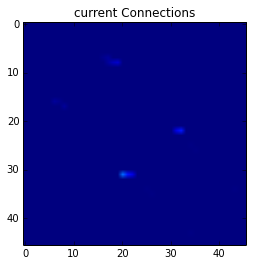

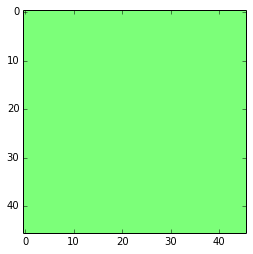

In [33]:
plt.imshow(connections*not_identity,vmin=0,vmax=1)
plt.title('current Connections')
plt.show()
plt.imshow(connections-a,vmin=-1,vmax=1)
a=connections

In [ ]:
# Need to analise the data

In [ ]:
# Auditory simulation:
alpha = 0.5
LR=0.9
asd=0
X=np.zeros(neurons.shape)
for i in range(100):
    #X = np.random.rand(N[0],N[1])
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    print F, D, i
    inp = generateMovingFFT(F,i,D)
    
    X=alpha*(np.dot(c_inp.T,inp) + 0.2*np.dot(connections,X))+(1-1.2*alpha)*np.dot(np.identity(X.size),X)
    X=sigmoid(X,1)
    plt.plot(X)
    plt.show()